# Выравнивание изображений номеров автомобилей
### Команда: **Keter**
#### Саляев Артём, Янковский Егор, Янковский Фёдор


## Алгоритм задачи

Алгоритм решения задачи в общем виде представлен на рисунке ниже. Реализуя процесс деформации изображений, было принято решение процедуру разделить на три этапа: 
1. с помощью нейронной сети решим задачу сегментации изображения и выделим номер автомобиля относительно всего изображения;
2. с помощью традиционных методов преобразования изображений очертим контур автомобильного номера и получим 3 или 4 точки, соответствующие углам автомобильного номера;
3. используя аффинные преобразования, преобразуем наше изображение к исходному шаблону для задачи.

![](https://sun9-2.userapi.com/impg/SfgCnkIYJeC_4clAh69dvC6ZwmBT9dLmMkh25A/DvScgey4ZCg.jpg?size=1916x1079&quality=96&sign=2ef5e9fadc1d8635c4963fb99affd07d&type=album)

## Шаг 0. Подготовительный

In [9]:
# Подключаем необходмые пакеты

from Modules.template import *
from Modules.model import *
import cv2 as cv
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split

In [3]:
# Объявляем рабочие директории

DATASET_PATH = 'images/'
MODEL_PATH = './resnet18_letters.pth'
LOCAL_PATH = 'temp_crops/'
images_pth = ['./images/' + p.name for p in Path('images').iterdir()]

In [4]:
# Функции для записи и удаления изображений

def writeTo(images, path):
    for i, image in enumerate(images):
        cv.imwrite(f'{path}{i}.jpg', image)

def removeFrom(path):
    for f in Path(path).iterdir():
        os.remove(f.absolute())

In [5]:
#Рисует на изображение template
def draw_regions(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
        raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    if len(img.shape) == 2:
        H,W = img.shape
    else:
        H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = int(sx * W), int(sy * H), int(ex * W), int(ey * H)
        cv.rectangle(img, (sx, sy), (ex, ey), (0, 255, 0), 2)

    return img

#Визуализирует изображения из датасета
def draw(folder_path, show_template=False, template=2):

    file_list = os.listdir(folder_path)
    image_files = [f for f in file_list if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Устанавливаем количество изображений на строку
    images_per_row = 5

    num_rows = len(image_files) // images_per_row + int(len(image_files) % images_per_row != 0)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    for i in range(num_rows * images_per_row):
        if i < len(image_files):
            ax = axes.flat[i]
            img_path = os.path.join(folder_path, image_files[i])
            img = cv.imread(img_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

            if show_template:
              img = img_deformation(img)
              img = cv.resize(img, (512,112))
              img_with_rectangles = draw_regions(img, template)

            ax.imshow(img)
            ax.axis('off')
            ax.set_title(os.path.basename(img_path))
        else:
            axes.flat[i].axis('off')

    plt.tight_layout()
    plt.show()


4O51MO5E


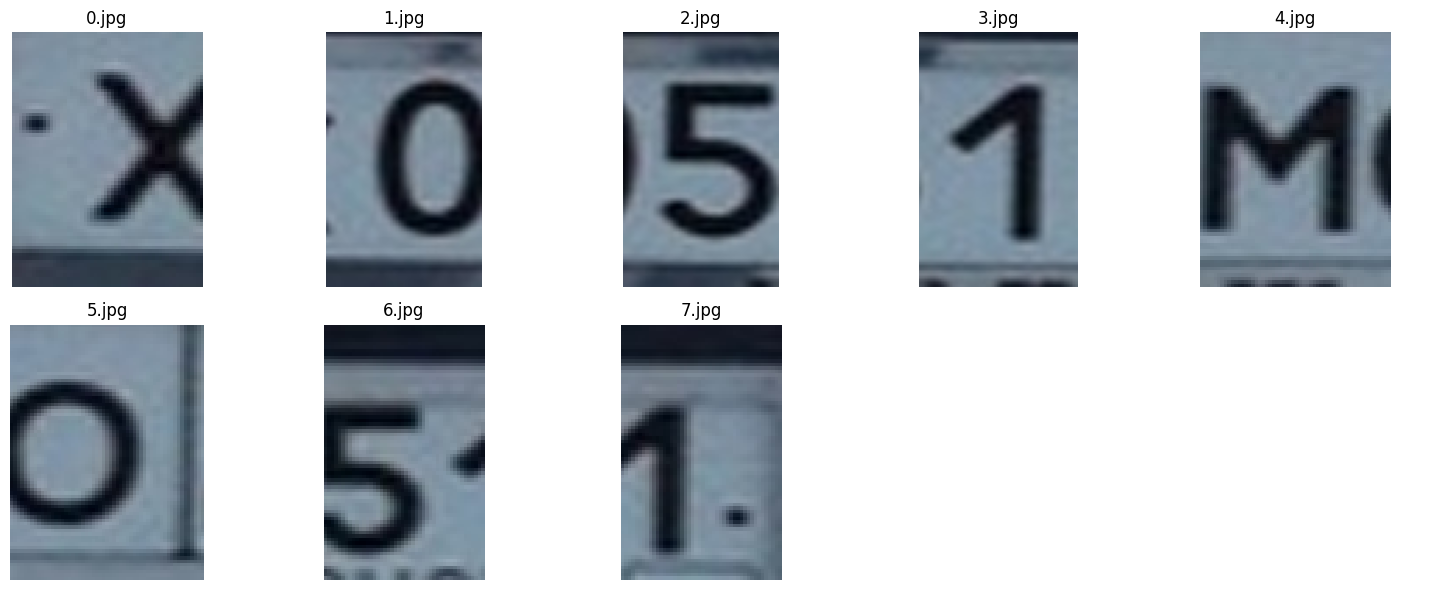

In [6]:
# Тестовый вывод без применения решения.
# Отрисовывем разбитое по шаблону изображение
# и выводим предсказание модели

test = cv.imread(images_pth[0])
test = cv.resize(test,(512, 112), fx=1, fy=1, interpolation=cv.INTER_CUBIC)

crops = apply_template(test, 2)
writeTo(crops, 'temp_crops/')

model = LettersPrediction()
print(model.predict_series(crops))

draw('temp_crops')
removeFrom('temp_crops/')

## Шаг 1. Использование нейросети

...
*Блоки кода*
...

In [36]:
def image_segmentation(img):
    img = cv.resize(img, (512, 112), fx=1, fy=1, interpolation=cv.INTER_CUBIC)

    model = YOLO('best.pt')
    results = model.predict(img, verbose=False)
    mask_raw = results[0].masks[0].cpu().data.numpy().transpose(1,2,0).astype(np.uint8)
    mask_raw = cv.resize(mask_raw, (512, 112), fx=1, fy=1, interpolation=cv.INTER_CUBIC)
    mask_raw = cv.merge((mask_raw,mask_raw,mask_raw))

    mask = cv.cvtColor(mask_raw, cv.COLOR_BGR2GRAY)
    return mask

## Шаг 2. Поиск угловых точек автомобильного номера

In [39]:
def remove_unnecessary_vertexes(vertexes, w, h):
    left_up =    [w, h]
    right_up =   [0, h]
    right_down = [0, 0]
    for vertex in vertexes:
        if left_up[0] ** 2 + left_up[1] ** 2 > vertex[0] ** 2 + vertex[1] ** 2:
            left_up = vertex
        if (w - right_up[0]) ** 2 + right_up[1] ** 2 > (w - vertex[0]) ** 2 + vertex[1] ** 2:
            right_up = vertex
        if (w - right_down[0]) ** 2 + (h - right_down[1]) ** 2 > (w - vertex[0]) ** 2 + (h - vertex[1]) ** 2:
            right_down = vertex
    return [left_up, right_up, right_down]

def adaptive(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (27,27), 0)
    #kernel = np.ones((5,5), np.uint8)
    thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, 2)
    return thresh

def global_thresh(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (17,17), 0)
    kernel = np.ones((5,5), np.uint8)
    ret, thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    return thresh

def stof_blur(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # blur
    blur = cv.GaussianBlur(gray, (0,0), sigmaX=33, sigmaY=33)
    # divide
    divide = cv.divide(gray, blur, scale=255)
    # otsu threshold
    thresh = cv.threshold(divide, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (1,1))
    morph = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
    return morph


def find_vertex(thresh):
    h, w = thresh.shape[0], thresh.shape[1]
    #img = cv.resize(img, (img.shape[0] * 3, img.shape[1] // 3), fx=1, fy=1, interpolation=cv.INTER_CUBIC)
    
    #thresh = adaptive(img)
    #thresh = global_thresh(img)
    #thresh = stof_blur(img)
    
    conts, hier = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = sorted(conts, key=cv.contourArea, reverse=True)[:5]
    
    points = []
    for cont in cnts:
        perimeter = cv.arcLength(cont, True)
        approx = cv.approxPolyDP(cont, 0.02 * perimeter, True)
        hull = cv.convexHull(approx, returnPoints=True)
        if len(hull) in range(1, 11) and cv.contourArea(hull) / 512 / 112 > 0.3:
            for point in hull:
                p = point[0]
                points.append(list(p))
            #cv.drawContours(img, [hull], -1, (0, 255,0 ), 1)
    vert = remove_unnecessary_vertexes(points, w ,h)
    #print(vert)
    return vert

Тестовая фигня (потом удалить) $\downarrow$

In [ ]:
not_null_contour_amount = 0
for i in np.arange(25, 40):
#for i in np.arange(len(images_pth)):
    img = cv.imread(images_pth[i])
    h, w = img.shape[0], img.shape[1]
    img = cv.resize(img, (512, 112), fx=1, fy=1, interpolation=cv.INTER_CUBIC)

    #thresh = adaptive(img)
    #thresh = global_thresh(img)
    thresh = stof_blur(img)

    conts, hier = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = sorted(conts, key=cv.contourArea, reverse=True)[:5]

    points = []
    for cont in cnts:
        perimeter = cv.arcLength(cont, True)
        approx = cv.approxPolyDP(cont, 0.02 * perimeter, True)
        hull = cv.convexHull(approx, returnPoints=True)
        if len(hull) in range(1, 11) and cv.contourArea(hull) / 512 / 112 > 0.3:
            for point in hull:
                p = point[0]
                points.append(list(p))
            cv.drawContours(img, [hull], -1, (0, 255,0 ), 2)
    vert = remove_unnecessary_vertexes(points, w ,h)
    if len(points) > 0: not_null_contour_amount+=1
    print(f"{i} {points} | {vert}")
    cv.imwrite(f'temp_crops/{i}.jpg', img)  

print("-----------------------------------")
print (not_null_contour_amount)
draw('temp_crops/')
removeFrom('temp_crops/')

## Шаг 3. Аффинные преобразования

In [20]:
def make_affine_transformations(img, vertexes):
    
    rows,cols,ch = img.shape
    pts1 = np.float32([vertexes[0], vertexes[1], vertexes[2]])
    pts2 = np.float32([[0, 0], [512, 0], [512, 112]])
    M = cv.getAffineTransform(pts1,pts2)
    dst = cv.warpAffine(img,M,(cols,rows))
    #fig, (ax1, ax2) = plt.subplots(ncols=2)
    #ax1.imshow(img)
    #ax2.imshow(dst)

    #for i in range(3):
    #    f = pts1[i]
    #    d = pts2[i]
    #    ax1.scatter(f[0], f[1], color='red')
    #    ax2.scatter(d[0], d[1], color='red')
    #plt.show()
    return dst


#img = cv.imread('0a6aa844e3834971.jpg')
#points = find_vertex(img)
#img1 = make_affine_transformations(img, points)

Тестовая фигня (потом удалить) $\downarrow$

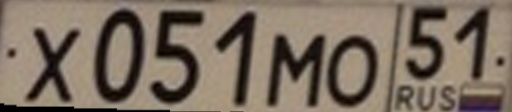

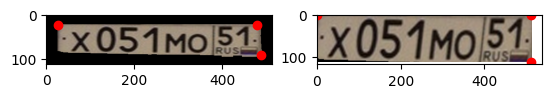

In [55]:
img = cv.imread(images_pth[0])


mask = image_segmentation(img)
vertexes = find_vertex(mask)

mask[mask == 1] = 255
img = cv.resize(img, (512, 112), fx=1, fy=1, interpolation=cv.INTER_CUBIC)
segmented_image = cv.bitwise_and(img, img, mask=mask)

rows,cols,_  = segmented_image.shape
pts1 = np.float32([vertexes[0], vertexes[1], vertexes[2]])
pts2 = np.float32([[0, 0], [512, 0], [512, 112]])


M = cv.getAffineTransform(pts1,pts2)
dst = cv.warpAffine(segmented_image,M,(cols,rows))


fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(segmented_image)
ax2.imshow(dst)

for i in range(3):
    f = pts1[i]
    d = pts2[i]
    ax1.scatter(f[0], f[1], color='red')
    ax2.scatter(d[0], d[1], color='red')
    #ax3.scatter(d[0], d[1], color='red')

Image.fromarray(dst)

In [ ]:
# Функция для деформации изображения

def img_deformation(img):
  # Шаг 1.
  img1 = image_segmentation(img)
  
  # Шаг 2.
  vertexes = find_vertex(img1)
  
  # Шаг 3.
  img3 = make_affine_transformations(img1, vertexes)
  return img3

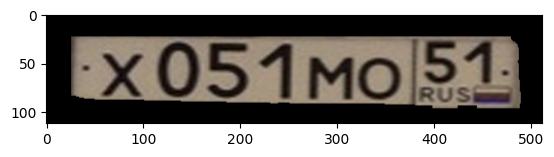

In [ ]:
img = cv.imread('fdc3e7b9662f7229.jpg')
img1 = image_segmentation(img)
vertexes = find_vertex(img1)
img3 = make_affine_transformations(img1, vertexes)


## Визуализация и проверка метрикой полученного результата

Визуализация по шаблону 2

In [ ]:
draw(DATASET_PATH, show_template=True)

Визуализация по шаблону 3

In [ ]:
draw(DATASET_PATH, show_template=True, template = 3)

## Вывод модели

Метрику будем вычислять по формуле:
$$Accuracy = \frac{\text{Количество правильных попадании}}{\text{Количество символов в номере}}.$$
Если номера имеют разную размерность, то возвращаем ноль.

In [ ]:
def metric(correct, prediction):
    correct_arr = list(correct)
    prediction_arr = list(prediction)
    if len(correct_arr) != len(prediction_arr): return 0.0
    correct_liter = 0
    for i in range(len(correct_arr)):
        if correct_arr[i] == prediction_arr[i]:
            correct_liter += 1
    return correct_liter    

In [ ]:
df = pd.read_csv('modelPredict.csv')
correct_df = pd.read_csv('correspondance.csv').sort_values(by = 'image_name')
merged_df = pd.merge(correct_df, df, on = "image_name", how = "inner")

In [ ]:
prediction_2 = []
prediction_3 = []
for i in range(len(merged_df)):
    prediction_2.append(int(metric(merged_df["number"][i], merged_df["prediction_region_length_2"][i])))
    prediction_3.append(int(metric(merged_df["number"][i], merged_df["prediction_region_length_3"][i])))

In [ ]:
merged_df.insert(4, "prediction2_correct_amount", prediction_2, True)
merged_df.insert(5, "prediction2_correct_accuracy", [value / 8.0 for value in prediction_2], True)
merged_df.insert(6, "prediction3_correct_amount", prediction_3, True)
merged_df.insert(7, "prediction3_correct_accuracy", [value / 9.0 for value in prediction_3], True)

In [ ]:
# Аварийная пилюля на случай если наделали лишних столбцов

merged_df = merged_df.drop("prediction2_correct_amount", axis=1)
merged_df = merged_df.drop("prediction2_correct_accuracy", axis=1)
merged_df = merged_df.drop("prediction3_correct_amount", axis=1)
merged_df = merged_df.drop("prediction3_correct_accuracy", axis=1)

In [ ]:
merged_df

In [ ]:
print(f"Avg accuracy for 2: {np.average([value / 8.0 for value in prediction_2])}")
print(f"Avg accuracy for 3: {np.average([value / 9.0 for value in prediction_3])}")